## Zernike

In [287]:
# imports
import glob 
import pickle
import pandas as pd
import seaborn as sns
from collections import Counter
from scipy.spatial.distance import pdist, squareform


In [325]:
zernike_paths = glob.glob('/scratch/user/grig0076/phlegm/PHROGs/phrog_representative_structures/phrog_predicted_oligomers/multimer_zernike_atom/*')

# read in the phrogs annotations so that these can be overlayed 
phrogs_df = pd.read_csv('/home/grig0076/scratch/databases/phrogs/phrog_annot_v4.tsv', sep='\t')
phrogs_df['phrog']  = ['phrog_' + str(p) for p in phrogs_df['phrog']] 
phrogs_category = dict(zip(phrogs_df['phrog'], phrogs_df['category']))
phrogs_annot = dict(zip(phrogs_df['phrog'], phrogs_df['annot']))

In [326]:
atom_multimer_zernike = dict()
for p in zernike_paths: 
    z = pickle.load(open(p, 'rb'))
    
    atom_multimer_zernike[list(z.keys())[0]] = z.get(list(z.keys())[0])
    
# convert to a dataframe 
atom_multimer_zernike = pd.DataFrame.from_dict(atom_multimer_zernike, orient='index')

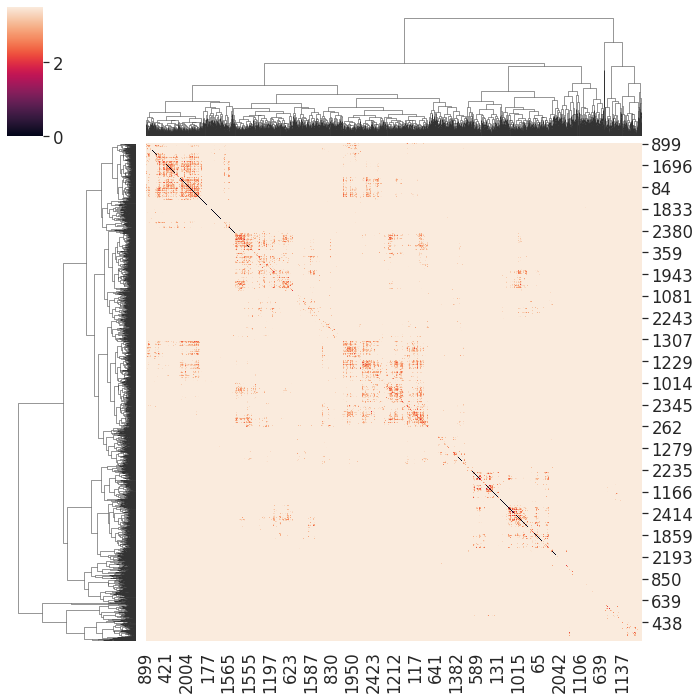

In [327]:
# calculate the euclidean distance between points 
dist_matrix = squareform(pdist(atom_multimer_zernike, metric="euclidean")) 
dist_matrix_df = pd.DataFrame(dist_matrix)
dist_matrix_df.columns = atom_multimer_zernike.index
dist_matrix_df.index = atom_multimer_zernike.index

# Convert square distance matrix to long form
dist_long_df = (
    dist_matrix_df
    .stack()
    .reset_index()
    .rename(columns={"level_0": "protein_1", "level_1": "protein_2", 0: "distance"})
)

# Drop rows where protein_1 == protein_2 (self-distances)
dist_long_df = dist_long_df[dist_long_df["protein_1"] != dist_long_df["protein_2"]]


sns.clustermap(pd.DataFrame(dist_matrix), vmax=3.5) # indicates that there might be proteins with similar oligomers 

In [328]:
dist_long_df.sort_values('distance').iloc[:20]

,protein_1,protein_2,distance
1330949,phrog_12711,phrog_1975,1.208976
4966569,phrog_1975,phrog_12711,1.208976
3441221,phrog_16945,phrog_12517,1.211349
1214561,phrog_12517,phrog_16945,1.211349
5893158,phrog_21569,phrog_14415,1.282485
2169478,phrog_14415,phrog_21569,1.282485
4301209,phrog_18458,phrog_2068,1.314404
5471149,phrog_2068,phrog_18458,1.314404
2686222,phrog_15392,phrog_13045,1.380981
1468478,phrog_13045,phrog_15392,1.380981


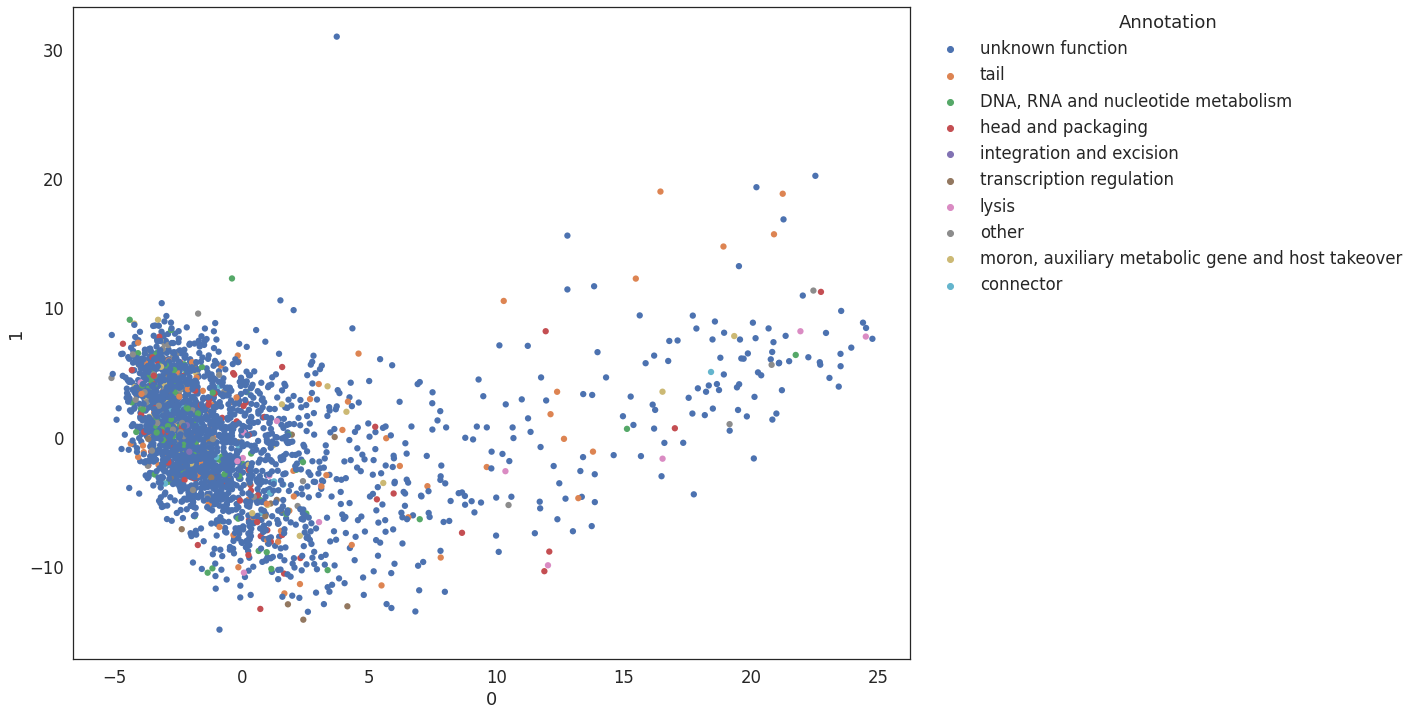

In [329]:
# If needed: pip install --user scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ----- config you can tweak -----
N_COMPONENTS  = 2
RANDOM_STATE  = 42
# --------------------------------

# Assume you already have: atom_multimer_zernike (rows = proteins, cols = descriptors)
df = atom_multimer_zernike.copy()

# Keep only numeric descriptor columns
num_cols = df.select_dtypes(include=[np.number]).columns
X = df[num_cols].to_numpy()

# Handle any NaNs/Infs gracefully
X = np.nan_to_num(X, copy=False, posinf=0.0, neginf=0.0)

# Standardize features
X_scaled = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

# PCA
pca = PCA(n_components=N_COMPONENTS, random_state=RANDOM_STATE)
embedding = pca.fit_transform(X_scaled)


pca_embedding = pd.DataFrame(embedding)
pca_embedding.index = atom_multimer_zernike.index
pca_embedding['category'] = [phrogs_category.get(i) for i in pca_embedding.index]
pca_embedding['annotation'] = [phrogs_annot.get(i) for i in pca_embedding.index]

# plot the tnse
plt.figure(figsize=(15, 12))
sns.set(style="white", font_scale=1.5)

sns.scatterplot(data = pca_embedding, x =0, y=1, linewidth=0, hue = 'category', s=40 )
# Move legend to the right
plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=False,
    title="Annotation"
)

In [330]:
# If needed: pip install --user scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ----- config you can tweak -----
PERPLEXITY     = 30          # typical: 5–50; must be < n_samples
N_ITER         = 1000        # 1000–2000 is common
RANDOM_STATE   = 42
PCA_COMPONENTS = 50          # set None to skip PCA
LEARNING_RATE  = "auto"      # or a number (e.g., 200)
# --------------------------------

# Assume you already have: atom_multimer_zernike (rows = proteins, cols = descriptors)
df = atom_multimer_zernike.copy()

# Keep only numeric descriptor columns
num_cols = df.select_dtypes(include=[np.number]).columns
X = df[num_cols].to_numpy()

# Handle any NaNs/Infs gracefully
X = np.nan_to_num(X, copy=False, posinf=0.0, neginf=0.0)

# Standardize features
X_scaled = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

# (Optional but recommended) PCA to speed up and denoise for t-SNE
if PCA_COMPONENTS is not None:
    X_in = PCA(n_components=PCA_COMPONENTS, random_state=RANDOM_STATE).fit_transform(X_scaled)
else:
    X_in = X_scaled


tsne = TSNE(
    n_components=2,
    perplexity=50,             # try 10, 30, 50, 100 (must be < n_samples)
    learning_rate="auto",      # or try 50, 200, 1000
    init="pca",                # also try "random"
    metric="cosine",
    method="exact",
    random_state=42,
    verbose=1,
)
embedding = tsne.fit_transform(X_in)  

embedding = tsne.fit_transform(X_in)


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 2517
[t-SNE] Computed conditional probabilities for sample 2000 / 2517
[t-SNE] Computed conditional probabilities for sample 2517 / 2517
[t-SNE] Mean sigma: 0.162063
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.343848
[t-SNE] KL divergence after 1000 iterations: 1.599413
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 2517
[t-SNE] Computed conditional probabilities for sample 2000 / 2517
[t-SNE] Computed conditional probabilities for sample 2517 / 2517
[t-SNE] Mean sigma: 0.162063
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.343848
[t-SNE] KL divergence after 1000 iterations: 1.599413


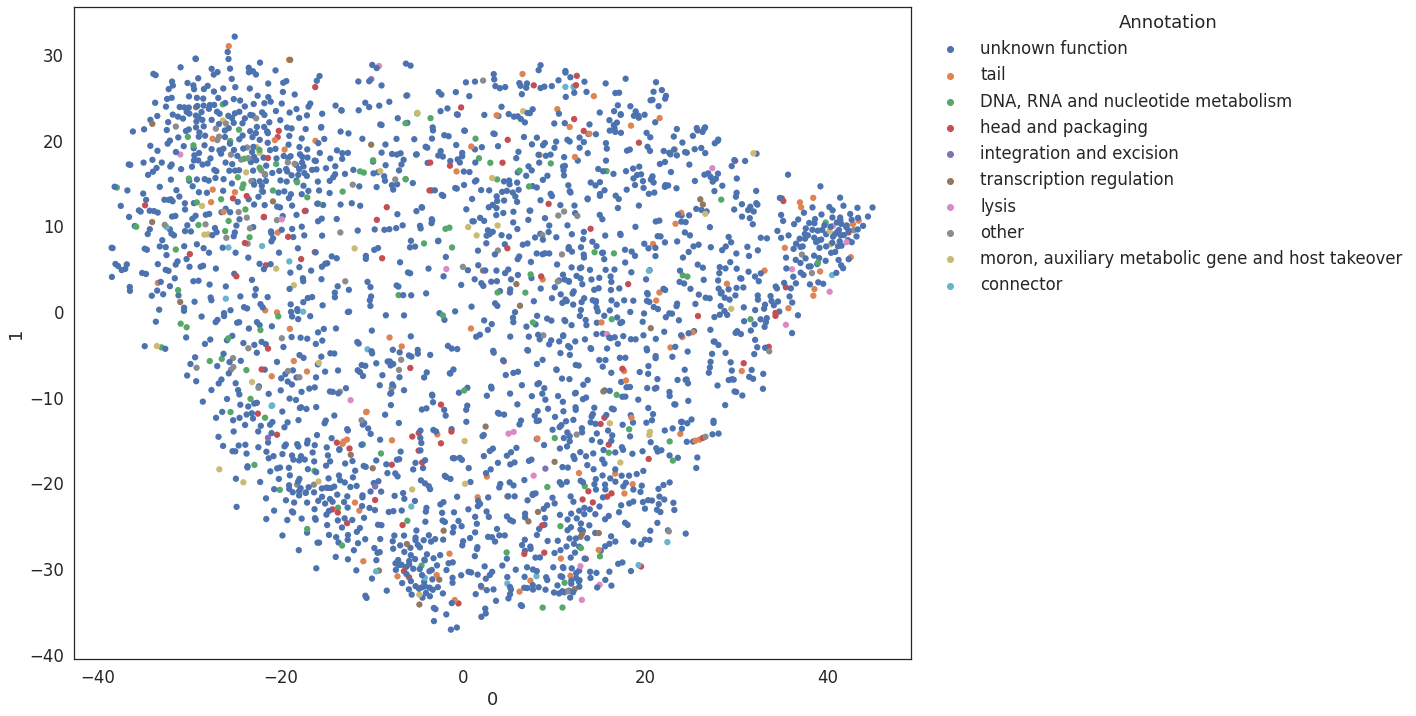

In [331]:
tsne_embedding = pd.DataFrame(embedding)
tsne_embedding.index = atom_multimer_zernike.index
tsne_embedding['category'] = [phrogs_category.get(i) for i in tsne_embedding.index]
tsne_embedding['annotation'] = [phrogs_annot.get(i) for i in tsne_embedding.index]

# plot the tnse
plt.figure(figsize=(15, 12))
sns.set(style="white", font_scale=1.5)

sns.scatterplot(data = tsne_embedding, x =0, y=1, linewidth=0, hue = 'category', s=40 )
# Move legend to the right
plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=False,
    title="Annotation"
)

In [323]:
top_annotations = pd.DataFrame.from_dict(Counter(tsne_embedding['annotation'].dropna()), orient='index').sort_values(0, ascending=False)[:20].index.to_list()

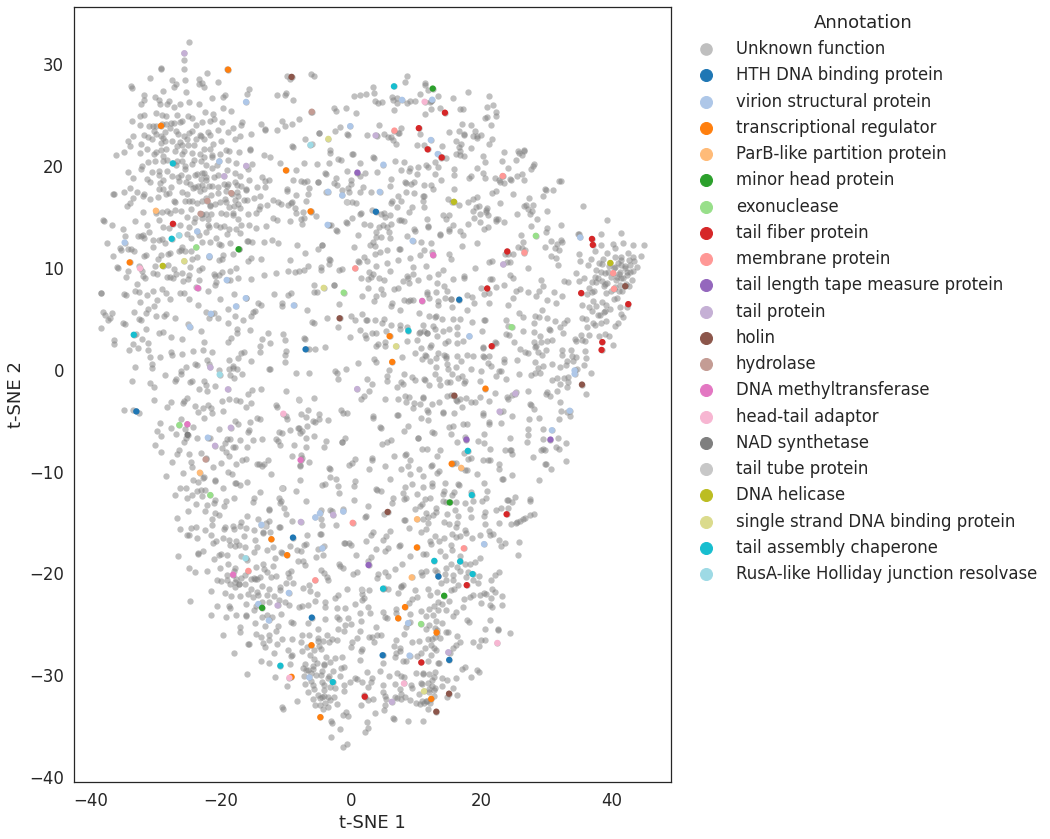

In [332]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 12))
sns.set(style="white", font_scale=1.5)

# Unknown function in grey
sns.scatterplot(
    data=tsne_embedding,
    x=0, y=1,
    linewidth=0, s=40,
    color='grey',
    alpha=0.5,
    label='Unknown function'
)

# Annotated functions
sns.scatterplot(
    data=tsne_embedding[tsne_embedding['annotation'].isin(top_annotations)],
    x=0, y=1,
    linewidth=0, s=40,
    hue='annotation',
    palette='tab20'
)

# Move legend outside to the right
plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=False,
    title="Annotation",
    markerscale=2
)

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


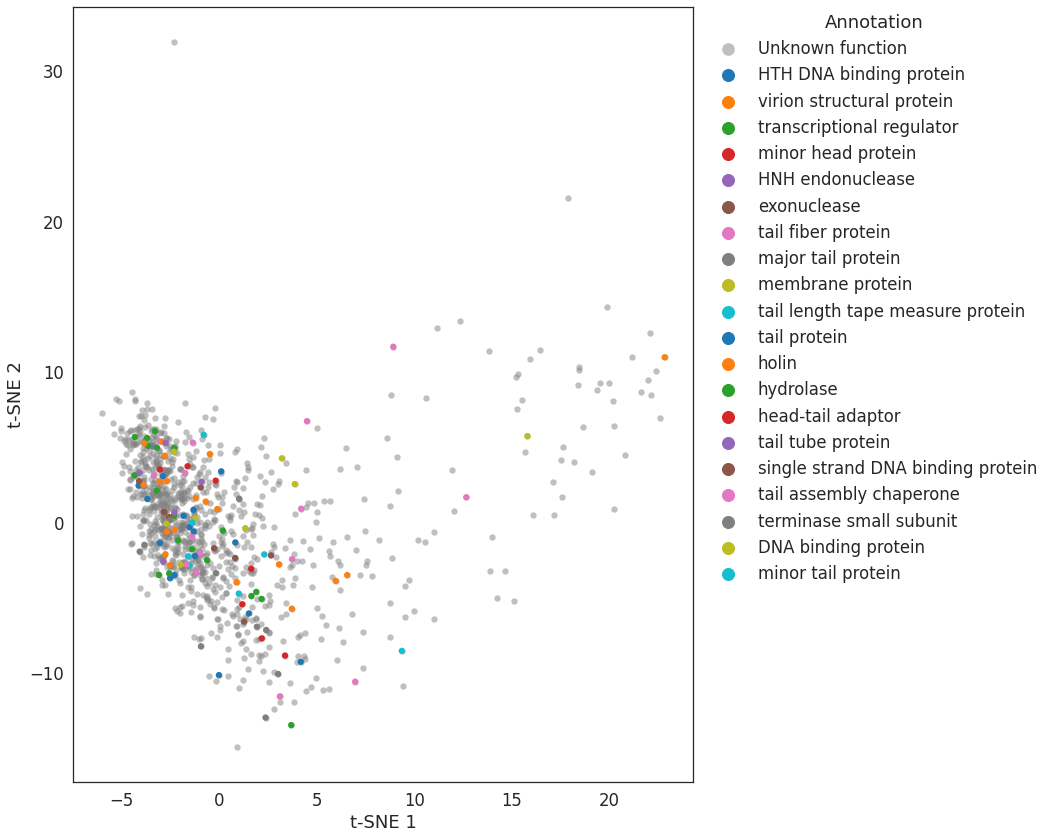

In [307]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 12))
sns.set(style="white", font_scale=1.5)

# Unknown function in grey
sns.scatterplot(
    data=pca_embedding,
    x=0, y=1,
    linewidth=0, s=40,
    color='grey',
    alpha=0.5,
    label='Unknown function'
)

# Annotated functions
sns.scatterplot(
    data=pca_embedding[pca_embedding['annotation'].isin(top_annotations)],
    x=0, y=1,
    linewidth=0, s=40,
    hue='annotation',
    palette='tab10'
)

# Move legend outside to the right
plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=False,
    title="Annotation",
    markerscale=2
)

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()
